In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import seaborn as sns
from scipy.stats import ttest_1samp
import sys
sys.path.append('..')
from helpers.funcs import *

In [3]:
config = json.load(open('../config.json', 'r'))
INPUT_DIR = config['INPUT_DIR']
OUTPUT_DIR = config['OUTPUT_DIR']
TWEET_DIR = config['TWEET_DIR']
NUM_CLUSTERS = config['NUM_CLUSTERS']
cluster_names = {v:k for k, v in config['CLUSTER_NAMES'].items()}

In [4]:
events = open(INPUT_DIR + 'event_names.txt', 'r').read().splitlines()
shooter_race = json.load(open(INPUT_DIR + "shooters_race.json","r"))

In [5]:
def split_party(part_tweets):
    return part_tweets[part_tweets['dem_follows'] > part_tweets['rep_follows']], part_tweets[part_tweets['dem_follows'] < part_tweets['rep_follows']]

In [7]:
def get_odds(tweets,  search):
    total = len(tweets)
    contains = tweets['text'].str.contains(search, case=True).sum()
    return (contains + 1) / ((total - contains) + 1)

In [1]:
shehe = r"\bshes\b|\bhe'd\b|\bhimself\b|\boneself\b|\bher\b|\bhes\b|\bhe's\b|\bshe'd\b|\bhed\b|\bhis\b|\bshe\b|\bhers\b|\bshe's\b|\bshe'll\b|\bherself\b|\bhim\b|\bhe\b"
we =r"\bwe\b|\bweve\b|\bwe've\b|\bwe'll\b|\bus\b|\blet's\b|\blets\b|\bwe'd\b|\bours\b|\bour\b|\bourselves\b|\bwe're\b"
you =r"\by'all\b|\byou're\b|\byoure\b|\byou'd\b|\bthy\b|\bthou\b|\bthee\b|\byoud\b|\bye\b|\byours\b|\bya\b|\byou'll\b|\bthine\b|\byou've\b|\bthoust\b|\byou\b|\byoull\b|\byour\b|\byall\b|\byouve\b"
they =r"\bthem\b|\btheyve\b|\btheyll\b|\bthey'll\b|\bthey've\b|\btheir*\b|\bthey'd\b|\bthey\b|\btheyd\b|\bthemselves\b"
I = r"\bi'll\b|\bive\b|\bmyself\b|\bi've\b|\bi\b|\bmine\b|\bme\b|\bi'd\b|\bim\b|\bi'm\b|\bmy\b"

In [9]:
pronoun_list = []
log_odds_list = []
race = []

for event in events:
    print(event)
    data = pd.read_csv(TWEET_DIR +event+'/'+event+'.csv', sep='\t', lineterminator='\n', usecols=['text', 'rep_follows', 'dem_follows', 'remove', 'isRT'])
    data = filter_retweets(data)
    data = data[~data['dem_follows'].isnull() & ~data['rep_follows'].isnull() & (data['dem_follows'] != data['rep_follows'])]
    data['text'] = data['text'].str.replace('’', "'")
    data['text'] = data['text'].str.lower()
    dem, rep = split_party(data)
    pronoun_list.append('SheHe')
    log_odds_list.append(np.log(get_odds(rep, shehe) / get_odds(dem, shehe)))
    race.append(shooter_race[event])
    pronoun_list.append('They')
    log_odds_list.append(np.log(get_odds(rep, they) / get_odds(dem, they)))
    race.append(shooter_race[event])
    pronoun_list.append('You')
    log_odds_list.append(np.log(get_odds(rep, you) / get_odds(dem, you)))
    race.append(shooter_race[event])    
    pronoun_list.append('I')
    log_odds_list.append(np.log(get_odds(rep, I) / get_odds(dem, I)))
    race.append(shooter_race[event])   
    pronoun_list.append('We')
    log_odds_list.append(np.log(get_odds(rep, we) / get_odds(dem, we)))
    race.append(shooter_race[event])

chattanooga
roseburg
colorado_springs
san_bernardino
kalamazoo
orlando
dallas
baton_rouge
burlington
fort_lauderdale
fresno
san_francisco
vegas
thornton
sutherland_springs
parkland
nashville
santa_fe
annapolis
pittsburgh
thousand_oaks


In [10]:
df = pd.DataFrame.from_dict({'pronoun':pronoun_list, 'log_odds':log_odds_list, 'race':race})

In [11]:
for i, g in df.groupby('pronoun'):
    print(i)
    print(ttest_1samp(np.array(g['log_odds']), 0))

I
Ttest_1sampResult(statistic=-12.414538099308121, pvalue=7.443194094080644e-11)
SheHe
Ttest_1sampResult(statistic=0.9275985948994289, pvalue=0.3646757440497098)
They
Ttest_1sampResult(statistic=-1.792103372500793, pvalue=0.08825913602391595)
We
Ttest_1sampResult(statistic=-9.401231603455237, pvalue=8.84319120815078e-09)
You
Ttest_1sampResult(statistic=-2.7692642946734534, pvalue=0.011833488349382368)


In [12]:
df.groupby('pronoun').median().sort_values('log_odds')

,log_odds
pronoun,
I,-0.255460
We,-0.223629
You,-0.158472
They,-0.061096
SheHe,0.041461


In [13]:
df.groupby('pronoun').mean().sort_values('log_odds')

,log_odds
pronoun,
I,-0.263889
We,-0.259392
You,-0.137308
They,-0.050638
SheHe,0.050441


[None, None]

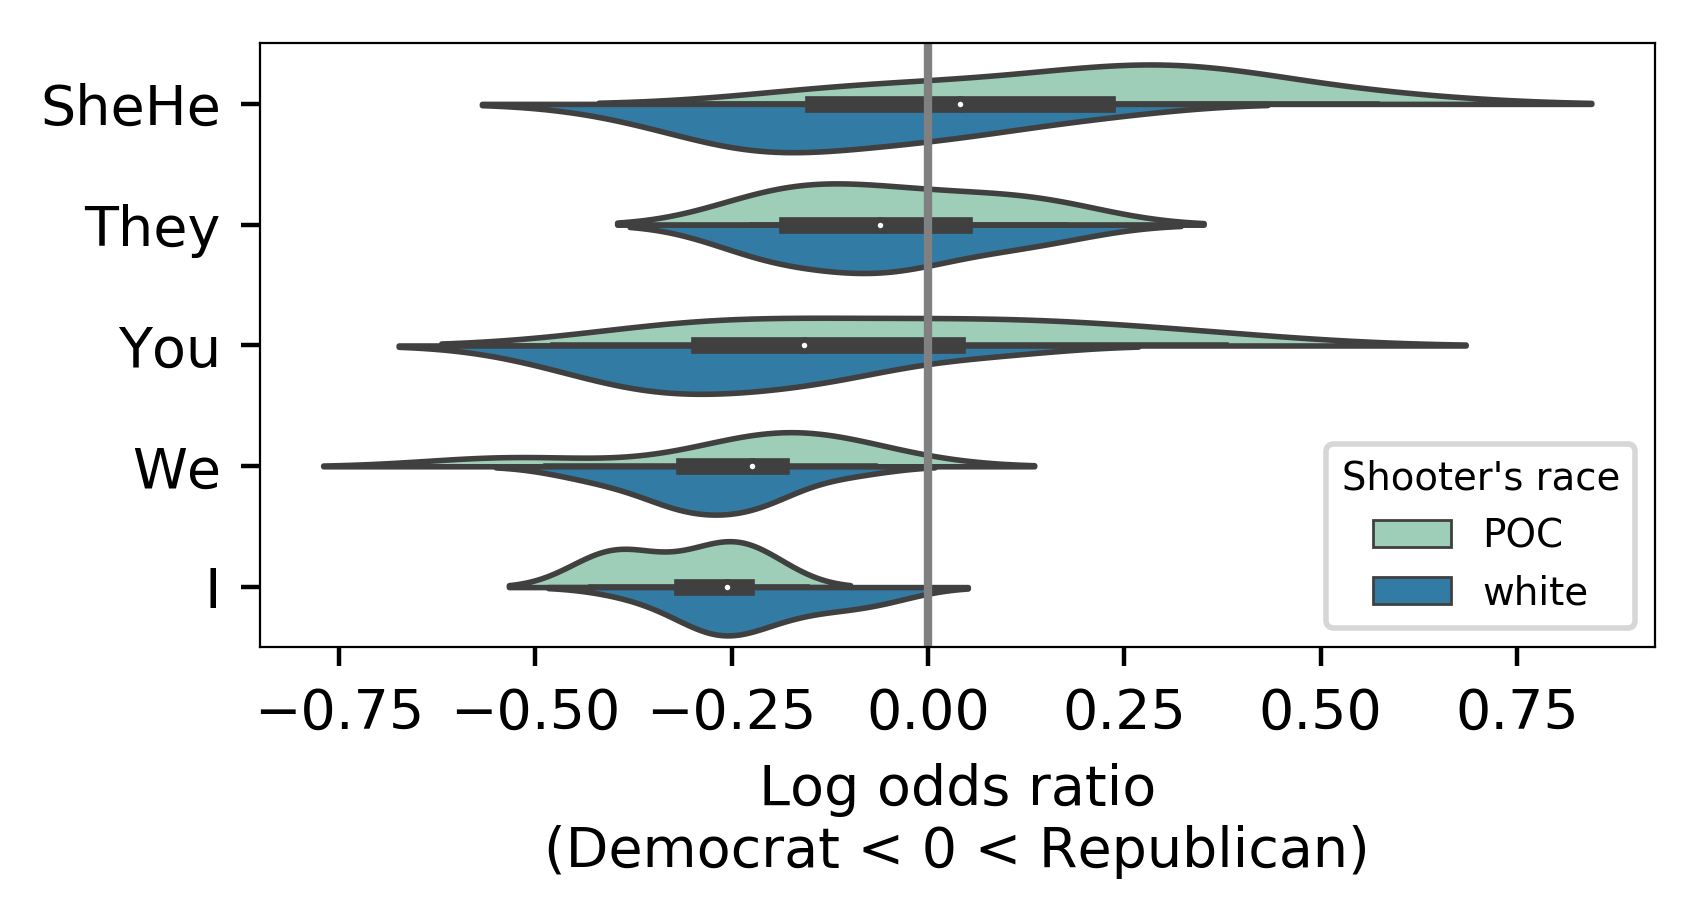

In [20]:
f = plt.figure(dpi=400, figsize=(4.5,2))
ax = sns.violinplot(data=df, x="log_odds",y="pronoun", hue='race', fliersize=1, linewidth=1, split=True, order=reversed(df.groupby('pronoun').median().sort_values('log_odds').index), orient="h", palette=sns.color_palette("YlGnBu", 2))
ax.set_ylabel('')
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
plt.axvline(x=0, color='grey')
ax.set_xlabel('Log odds ratio\n(Democrat < 0 < Republican)')
legend = ax.legend(loc='lower right', title="Shooter's race", fontsize=7)
plt.setp(legend.get_title(),fontsize='x-small')

# distribution of pronouns across topics

In [21]:
pronoun_list = []
topic_list = []
value_list = []
event_list = []

def print_distr(event, name, s, total_props):
    print(name)
    b = np.bincount(s['topic'])
    vals = (b / np.sum(b)) / total_props
    #print(((b / np.sum(b)) / total_props))
    for i in range(NUM_CLUSTERS):
        topic_list.append(cluster_names[i])
        value_list.append(vals[i])
        pronoun_list.append(name)
        event_list.append(event)
        

for event in events:
    print(event)
    data = pd.read_csv(TWEET_DIR + event + '/' + event + '.csv', sep='\t', lineterminator='\n',
                       usecols=['user_id', 'text'])
    data = get_cluster_assignments(event, data, 'relative')
    total_props = np.bincount(data['topic']) / np.sum(np.bincount(data['topic']))

    
    s = data[data['text'].str.contains(shehe, case=True)]
    try:
        print_distr(event, 'SheHe', s, total_props)
    except:
        pass
    
    s = data[data['text'].str.contains(they, case=True)]
    try:
        print_distr(event, 'They', s, total_props)
    except:
        pass
    
    s = data[data['text'].str.contains(you, case=True)]
    try:
        print_distr(event, 'You', s, total_props)
    except:
        pass
    s = data[data['text'].str.contains(I, case=True)]
    try:
        print_distr(event, 'I', s, total_props)
    except:
        pass
    
    s = data[data['text'].str.contains(we, case=True)]
    try:
        print_distr(event, 'We', s, total_props)
    except:
        pass

chattanooga
SheHe
They
You
I
We
roseburg
SheHe
They
You
I
We
colorado_springs
SheHe
They
You
I
We
san_bernardino
SheHe
They
You
I
We
kalamazoo
SheHe
They
You
I
We
orlando
SheHe
They
You
I
We
dallas
SheHe
They
You
I
We
baton_rouge
SheHe
They
You
I
We
burlington
SheHe
They
You
I
We
fort_lauderdale
SheHe
They
You
I
We
fresno
SheHe
They
You
I
We
san_francisco
SheHe
They
You
I
We
vegas
SheHe
They
You
I
We
thornton
SheHe
They
You
I
We
sutherland_springs
SheHe
They
You
I
We
parkland
SheHe
They
You
I
We
nashville
SheHe
They
You
I
We
santa_fe
SheHe
They
You
I
We
annapolis
SheHe
They
You
I
We
pittsburgh
SheHe
They
You
I
We
thousand_oaks
SheHe
They
You
I
We


In [22]:
df = pd.DataFrame.from_dict({'pronoun':pronoun_list, 'proportion':value_list, 'topic':topic_list, 'event':event_list})

In [23]:
df.to_csv(OUTPUT_DIR + 'pronoun_distributions.csv')

In [24]:
df

,pronoun,proportion,topic,event
0,SheHe,1.295797,shooter's identity\n& ideology,chattanooga
1,SheHe,0.415145,news,chattanooga
2,SheHe,0.610684,victims & location,chattanooga
3,SheHe,0.633724,laws & policy,chattanooga
4,SheHe,2.217813,investigation,chattanooga
5,SheHe,0.364782,solidarity,chattanooga
6,SheHe,0.770124,remembrance,chattanooga
7,SheHe,1.971931,other,chattanooga
8,They,0.645574,shooter's identity\n& ideology,chattanooga
9,They,0.177675,news,chattanooga
